# Imports and Data Munging

In [2]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

#make the layout full width
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#prefer locally cached copy of SQL Server data
runSql = False

### Load the tip data

In [5]:
tips= pd.read_csv('JL.csv')
tips['DATE'] = pd.to_datetime(tips['DATE'], format="%d/%m/%Y")
tips.head()

,DATE,EVENT,RACE,NO.,SELECTION,UNITS INVESTED,MARKET TYPE,W.E.I. ODDS,RESULT,UNITS COLLECTED,P/L,EMAIL ODDS,AVAILABLE ODDS,BEST FIXED EMAIL SENT,BEST FIXED CLOSING
0,2017-09-01,ASHBURTON,3,6,MISS SPECIAL,0.4,Win,15.0,0,0.0,-0.4,15.0,16.00,15.0,6.50
1,2017-09-01,ASHBURTON,3,6,MISS SPECIAL,0.8,Place,5.5,2,4.4,3.6,5.5,6.00,5.5,3.10
2,2017-09-01,WYONG,5,3,WIDE ACCLAIM,0.5,Win,8.6,0,0.0,-0.5,8.0,8.50,8.0,8.50
3,2017-09-01,WYONG,5,3,WIDE ACCLAIM,1.0,Place,2.7,0,0.0,-1.0,2.7,2.88,2.7,2.62
4,2017-09-02,HASTINGS,7,7,GINGERNUTS,0.4,Win,14.0,0,0.0,-0.4,14.0,17.00,14.0,6.00


### Calculate tip delta and tip delta rounded

In [8]:
tips['DELTA'] = (tips['BEST FIXED EMAIL SENT'] - tips['BEST FIXED CLOSING']) / tips['BEST FIXED EMAIL SENT']
tips['DELTA ROUNDED'] = tips['DELTA'].apply(lambda x: round(x, 1))
tips.head()

,DATE,EVENT,RACE,NO.,SELECTION,UNITS INVESTED,MARKET TYPE,W.E.I. ODDS,RESULT,UNITS COLLECTED,P/L,EMAIL ODDS,AVAILABLE ODDS,BEST FIXED EMAIL SENT,BEST FIXED CLOSING,DELTA,DELTA ROUNDED
0,2017-09-01,ASHBURTON,3,6,MISS SPECIAL,0.4,Win,15.0,0,0.0,-0.4,15.0,16.00,15.0,6.50,0.566667,0.6
1,2017-09-01,ASHBURTON,3,6,MISS SPECIAL,0.8,Place,5.5,2,4.4,3.6,5.5,6.00,5.5,3.10,0.436364,0.4
2,2017-09-01,WYONG,5,3,WIDE ACCLAIM,0.5,Win,8.6,0,0.0,-0.5,8.0,8.50,8.0,8.50,-0.062500,-0.1
3,2017-09-01,WYONG,5,3,WIDE ACCLAIM,1.0,Place,2.7,0,0.0,-1.0,2.7,2.88,2.7,2.62,0.029630,0.0
4,2017-09-02,HASTINGS,7,7,GINGERNUTS,0.4,Win,14.0,0,0.0,-0.4,14.0,17.00,14.0,6.00,0.571429,0.6


### Grouping and display

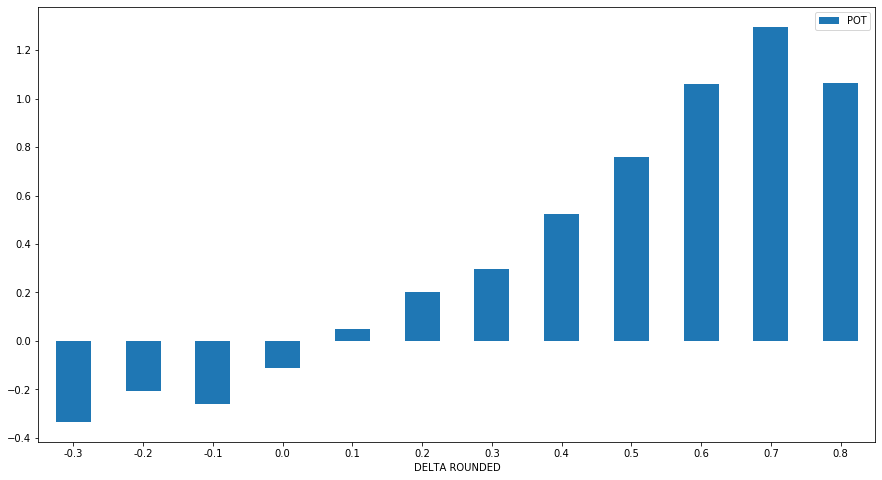

In [30]:
tipsGrouped = tips.groupby(['DELTA ROUNDED']).agg({'P/L':'sum','UNITS INVESTED':'sum' }).reset_index()
tipsGrouped['POT'] = tipsGrouped['P/L'] / tipsGrouped['UNITS INVESTED']

tipsGrouped

tipsGrouped[(tipsGrouped['DELTA ROUNDED'] > -0.4) & (tipsGrouped['DELTA ROUNDED'] < 0.9)].plot.bar(x='DELTA ROUNDED', y='POT', rot=0, figsize=(15,8))

In [28]:
tipsGrouped

,DELTA ROUNDED,P/L,UNITS INVESTED,POT
0,-2.1,-0.30,0.30,-1.000000
1,-1.5,-0.50,0.50,-1.000000
2,-1.4,-1.00,1.00,-1.000000
3,-1.3,-1.30,1.30,-1.000000
4,-1.2,-1.00,1.00,-1.000000
5,-1.1,-0.50,0.50,-1.000000
6,-1.0,8.20,2.00,4.100000
7,-0.9,-1.87,4.55,-0.410989
8,-0.8,-5.10,5.10,-1.000000
9,-0.7,-7.48,9.80,-0.763265
